In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
#from torchvision.datasets import MNIST

In [5]:
print(torch.__version__)

1.6.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
#import os
#os.chdir("/content/drive/My Drive") 
import ra
#import complexLayers


In [3]:
dataset = ra.read('atomsroa.ra')
train_data = torch.tensor(dataset)

In [4]:
train_data = train_data.imag
train_data =  torch.transpose(train_data, 0, 1).unsqueeze(1)

In [5]:
labelset = ra.read('paramsroa.ra')
train_label1 = torch.tensor(labelset)

In [7]:
dataset1 = ra.read('atoms.ra')
traindata1 = torch.tensor(dataset1)
traindata1 = traindata1.imag
traindata1 =  torch.transpose(traindata1, 0, 1).unsqueeze(1)
label1 = ra.read('params.ra')
label1 = torch.tensor(label1)

MemoryError: 

In [ ]:
print(traindata1)
print(train_data)

In [ ]:
print(traindata1.shape)
train_data.shape

In [ ]:
alldata = torch.cat((train_data,traindata1),0)

In [ ]:
labels1 = torch.cat((train_label1[0,:],label1[0,:]),0)

In [ ]:
print(labels1)
print(labels1.shape)
print(train_label1.shape)

In [16]:
labels1 = torch.transpose(labels1)
print(labels1.shape)

TypeError: transpose() received an invalid combination of arguments - got (Tensor), but expected one of:
 * (Tensor input, name dim0, name dim1)
 * (Tensor input, int dim0, int dim1)


In [17]:
import torch.utils.data as data
train_dataset = data.TensorDataset(alldata,labels1)

In [ ]:
from sklearn.decomposition import PCA
X_reduced = PCA(n_components=10).fit_transform(train_data)

In [ ]:
pca = PCA(n_components=10)
pca.fit(train_data)

print(pca.explained_variance_ratio_.shape)
print(pca.components_.shape)
print(pca.singular_values_.shape)
print(pca.mean_.shape)

In [ ]:
train_data = torch.tensor(X_reduced)

In [18]:
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [140000, 60000 ,16112])

We found that the network model with smallest
average error for validation data consists of 3 convolutional layers (kernel size = 3, stride
size = 2), each followed by a rectified linear unit (ReLU) activation function. The number
of the feature maps per convolutional layer is increasing, from 32 in the first to 128 in
the last. After convolution an average pooling layer follows with the same size as the
stride size. The last layer is fully connected, with 2 outputs. 

In [19]:

# define baseline model
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=9, stride=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=9, stride=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=9, stride=2)
        self.fc1 = nn.Linear(7040, 1)


    def forward(self, x):
        out = self.conv1(x)
        out = torch.relu(out)                                        
        out = self.conv2(out)
        out = torch.relu(out)
        out = self.conv3(out)
        out = torch.relu(out)
        out = F.avg_pool1d(out, kernel_size=9, stride=2)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

In [20]:
N = 200
val_loss = list()
#val_accu = list()
train_loss = list()
#train_accu = list()

In [21]:
#assert torch.cuda.is_available()
device1 = "cuda:0" if torch.cuda.is_available() else "cpu"
#cuda_device = torch.device("cuda")
seed = 7
torch.manual_seed(seed)
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

def loss_batch(model, loss_func, xb, yb, opt=None):
    outputs = model(xb.float())
    yb = yb.float()
    outputs = torch.squeeze(outputs, 1)
    loss = loss_func(outputs, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [ ]:
!pip install pycuda
import torch
import pycuda.driver as cuda
cuda.init()
## Get Id of default device
torch.cuda.current_device()
# 0
cuda.Device(0).name() # '0' is the id of your GPU

In [22]:

# build the model
model = BaselineModel().to(device1)

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

# the epoch loop
for epoch in range(N):
    model.train()
    running_loss = 0.0
    loss=0
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        #inputs = inputs.unsqueeze(1).unsqueeze(-1)
        #inputs = inputs.unsqueeze(1)
        #inputs = torch.unsqueeze(inputs1, 2)

        inputs, labels = inputs.to(device1), labels.to(device1)
        
        
        loss, nums = loss_batch(model, loss_function, inputs.float(), labels.float(), optimiser)
        running_loss += loss
    train_loss.append(loss)

    model.eval()
    with torch.no_grad():
        losses, nums = zip(
                *[loss_batch(model.to(device1), loss_function, xb.to(device1), yb.to(device1)) for xb, yb in validloader]
            )
        val_loss1 = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_loss.append(val_loss1)


        #print(epoch, val_loss)

        
        # keep track of the loss this epoch
        #running_loss += loss.item()
    print("Epoch %d, loss %4.2f" % (epoch, running_loss))
print('**** Finished Training ****')

Epoch 0, loss 985491949.69
Epoch 1, loss 201250019.84
Epoch 2, loss 73119171.28
Epoch 3, loss 50260394.42
Epoch 4, loss 36088539.24
Epoch 5, loss 26047168.70
Epoch 6, loss 19595281.48
Epoch 7, loss 14558511.39
Epoch 8, loss 10639754.13
Epoch 9, loss 8296568.72
Epoch 10, loss 6495683.85
Epoch 11, loss 5320079.03
Epoch 12, loss 4814930.10
Epoch 13, loss 4098426.75
Epoch 14, loss 3882945.54
Epoch 15, loss 3434900.35
Epoch 16, loss 3081028.17
Epoch 17, loss 2807924.16
Epoch 18, loss 2702019.77
Epoch 19, loss 2473384.24
Epoch 20, loss 2333554.28
Epoch 21, loss 2239736.45
Epoch 22, loss 2127566.50
Epoch 23, loss 1942440.59
Epoch 24, loss 1923837.50
Epoch 25, loss 1742278.40
Epoch 26, loss 1635233.93
Epoch 27, loss 1539586.17
Epoch 28, loss 1606262.88
Epoch 29, loss 1424053.52
Epoch 30, loss 1423602.91
Epoch 31, loss 1397838.30
Epoch 32, loss 1235595.70
Epoch 33, loss 1249790.24
Epoch 34, loss 1183529.25
Epoch 35, loss 1115977.10
Epoch 36, loss 1146589.14
Epoch 37, loss 1061274.46
Epoch 38, l

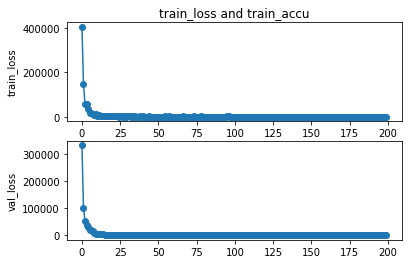

In [24]:
import matplotlib.pyplot as plt

x = range(0, N)
y1 = train_loss
#y2 = train_accu
y3 = val_loss
#y4 = val_accu
plt.subplot(2, 1, 1)
plt.plot(x, y1, 'o-')
plt.title('train_loss and val_loss')
plt.ylabel('train_loss')
#plt.subplot(2, 1, 2)
#plt.plot(x, y2, '.-')
#plt.xlabel('epoches')
#plt.ylabel('train_accu')
plt.subplot(2, 1, 2)
plt.plot(x, y3, 'o-')
plt.ylabel('val_loss')
#plt.subplot(2, 2, 2)
#plt.plot(x, y4, '.-')
#plt.title('val_loss and val_accu')
#lt.ylabel('val_accu')
plt.show()
#plt.savefig("accuracy_loss.jpg")


In [24]:
print(y1)

[39162.5859375, 11763.650390625, 10699.044921875, 5103.5830078125, 4158.6142578125, 3056.337890625, 1703.7333984375, 1637.2615966796875, 1261.2879638671875, 1131.3231201171875, 1172.2281494140625, 1134.0067138671875, 678.216796875, 860.5421752929688, 1129.3348388671875, 630.5377197265625, 609.3250732421875, 568.7601318359375, 420.55645751953125, 319.82196044921875, 823.774658203125, 361.33343505859375, 336.67626953125, 302.5008544921875, 209.6558837890625, 315.412353515625, 342.5613708496094, 273.7820739746094, 166.2567138671875, 225.6500701904297, 247.6725311279297, 274.4014892578125, 310.10772705078125, 198.839111328125, 673.5882568359375, 266.2223205566406, 367.98138427734375, 179.63232421875, 228.9575653076172, 173.31272888183594, 252.89376831054688, 261.2034606933594, 175.7914276123047, 189.5096893310547, 148.1826171875, 178.23191833496094, 144.52645874023438, 137.4016876220703, 136.2789306640625, 249.77658081054688, 128.30670166015625, 1062.2835693359375, 158.63011169433594, 298.

In [21]:
print(train_loss) #1007

[53875.3984375, 10538.388671875, 7801.8232421875, 3676.34228515625, 3547.56591796875, 3139.117919921875, 1558.3216552734375, 1712.720703125, 1032.89794921875, 1184.35009765625, 1572.6766357421875, 604.29736328125, 1269.781005859375, 596.0618896484375, 469.68743896484375, 564.84521484375, 594.2720336914062, 623.07666015625, 384.596435546875, 412.0712585449219, 428.4090270996094, 345.9783630371094, 353.8318786621094, 444.24456787109375, 323.6316833496094, 621.7431640625, 651.2526245117188, 396.43841552734375, 400.9185791015625, 778.3173217773438, 650.2574462890625, 359.94793701171875, 350.77960205078125, 536.6001586914062, 216.06521606445312, 197.510986328125, 149.714111328125, 98.7204818725586, 214.0364990234375, 1210.504638671875, 543.467041015625, 145.90805053710938, 225.9866180419922, 193.2469482421875, 225.39476013183594, 122.2555160522461, 134.29791259765625, 95.68473815917969, 150.3511199951172, 231.0721893310547, 123.8434066772461, 161.4438018798828, 117.80247497558594, 190.02059

In [25]:
print(y3)

[47070.75850833333, 14160.651023958333, 9504.357263541666, 5064.385265625, 3622.789198177083, 2555.7030783854166, 2865.3562497395833, 1652.871702669271, 1416.6655591796875, 2500.3363373697916, 1207.1820396484375, 824.034502734375, 846.8916470052084, 772.3470776692708, 959.6251580729166, 690.0691931640625, 706.3094733723958, 439.104155859375, 455.1469000325521, 599.4429361979167, 347.8273849609375, 325.42639397786456, 351.883117578125, 539.8078697916667, 335.9686100911458, 304.3679769856771, 294.8450935546875, 257.3579281901042, 332.04665408528643, 238.25290834147137, 273.2392374348958, 517.3467895996093, 242.07539473470052, 270.023981656901, 337.67350498046875, 307.2629343424479, 512.965322672526, 395.36957345377607, 242.02395505371095, 147.75177530924478, 285.53247884114586, 208.88724529622397, 163.93382548828126, 145.00982801513672, 144.96418704427083, 170.4312279296875, 179.63603095703124, 157.23783223470053, 145.18841010742187, 139.32339187825522, 150.5882546875, 1176.737731640625,

In [20]:
print(val_loss) #1007

[47032.243502083336, 11922.345719791667, 6727.807554166667, 3970.2100994791667, 3329.2127307291667, 3158.0020705729166, 1649.4982531901042, 1659.7574899739584, 1689.3991966796875, 975.2430866536458, 1061.6506720052084, 934.1577599609375, 864.43433671875, 644.9809009440104, 879.6912348307292, 638.1379388671875, 520.0445943684896, 465.6540364908854, 399.78822400716143, 428.4530332356771, 379.70518929036456, 606.8722819986979, 559.0067360677083, 319.24973971354166, 457.02387431640625, 436.6217994466146, 257.5055552083333, 370.48293072916664, 255.8283421549479, 251.92656153971353, 218.11864221191405, 581.4902156575521, 313.8683263997396, 292.5577657552083, 264.1963776041667, 242.17569438476562, 211.11292587890625, 171.45502568359376, 232.3327527669271, 816.8054049804688, 325.8771190266927, 160.47577391764324, 384.084596891276, 246.7594884765625, 298.55835857747394, 124.60502587890625, 140.8620880859375, 135.35086702473959, 165.69561534016927, 230.12462009277343, 118.03113334147136, 151.184

In [29]:
model.eval()

BaselineModel(
  (conv1): Conv1d(1, 32, kernel_size=(9,), stride=(2,))
  (conv2): Conv1d(32, 64, kernel_size=(9,), stride=(2,))
  (conv3): Conv1d(64, 128, kernel_size=(9,), stride=(2,))
  (fc1): Linear(in_features=7040, out_features=1, bias=True)
)

In [25]:
model.eval()
test_loss = list()
for data in testloader:
    losses, nums = zip(
                *[loss_batch(model.to(device1), loss_function, xb.to(device1), yb.to(device1)) for xb, yb in testloader])
    test_loss1 = np.sum(np.multiply(losses, nums)) / np.sum(nums)
    test_loss.append(test_loss1)

In [26]:
import matplotlib.pyplot as plt

In [28]:
print(y3)

[72.64885924565638, 72.64885964720347, 72.64885897290742, 72.64885912443462, 72.64885943506538, 72.64885966993255, 72.64885908655282, 72.6488588819911, 72.64885985934154, 72.64885905624737, 72.64885950325262, 72.64885904109467, 72.64885944264174, 72.6488595259817, 72.64885935930178, 72.64885912443462, 72.64885904109467, 72.64885896911925, 72.64885926838546, 72.64885925323274, 72.64885893502561, 72.6488589766956, 72.64885885168566, 72.64885877592206, 72.6488597532725, 72.6488592608091, 72.64885917746915, 72.64885932899634, 72.64885982524792, 72.64885977600159, 72.64885932899634, 72.64885949946444, 72.64885944264174, 72.64885957522804, 72.64885945779446, 72.6488591092819, 72.64885917746915, 72.6488592608091, 72.64885998813966, 72.64885949188809, 72.6488588062275, 72.6488592229273, 72.64885913579916, 72.64885968508526, 72.64885957901622, 72.64885902594195, 72.64885911685826, 72.64885935930178, 72.64885921535094, 72.64885948052354, 72.64885923808002, 72.64885930626725, 72.64885904867103, 7

Text(0, 0.5, 'test_loss')

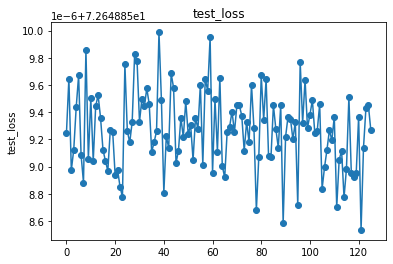

In [27]:
x = range(0, 126)
y3 = test_loss
plt.plot(x, y3, 'o-')
plt.title('test_loss')
plt.ylabel('test_loss')

In [31]:
for data in testloader:
    #print(data)
    inputs, lablels = data
    predictions = model(inputs.float())
    loss = loss_function(predictions,labels)
    losst1=loss_function(predictions[:,0],labels[:,0])
    losst1=loss_function(predictions[:,1],labels[:,1])
    loss = loss/128
    print("loss",loss)
    print("losst1",losst1)
    print("losst2",losst2)
    #print("predicted parameter:", predictions)
    #print("setting parameter:", labels)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [ ]:
testdataset = ra.read('atomsroa.ra')
testdata = torch.tensor(testdataset)
testdata = testdata.imag
label1 = ra.read('paramsroa.ra')
label1 = torch.tensor(label1)

In [ ]:
for i in range(8056):
    inputs = testdata[:,i]
    lablels = label1[0,i]
    predictions = model(inputs.float())

    print("predicted parameter:", predictions)
    print("setting parameter:", lablels)

## Saving models

Being able to train a model is fine, but in practice once we've trained the model we probably want to save the result so we can reuse it at a later time. PyTorch makes saving the model easy using the torch.save(state, filepath) function. This will save the weights of the model so they can be loaded into a new instance at a later point.

Run the following code to save the weights for use in the next part of the lab.

In [17]:
#save the trained model weights
torch.save(model.state_dict(), "./BaselineModel.weights")

If you are running on Colab, run the following to download the weights to the local machine:

In [ ]:
from google.colab import files
files.download('BaselineModel.weights')

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = BaselineModel(1000, 512, 256).to(device)
model.load_state_dict(torch.load('BaselineModel.weights'))